In [1]:
import tftables
import tensorflow as tf
import numpy as np
import time

In [90]:
def input_transform(tbl_batch):
    data = tbl_batch['spectrum']
    metals = tbl_batch['MH_ratio']

    data_float = tf.to_float(data)
    metals_float = tf.to_float(metals)

    data_slice = data_float[:, 700000:750000] # let's try just training on a portion of the spectrum
    
    data_max = tf.reduce_max(data_slice, axis=1)
    normalized_data = tf.divide(data_slice,
                                tf.expand_dims(data_max, axis=1))
    
    return normalized_data, metals_float

In [91]:
def create_layer(n_in, n_out, index):
    weight = tf.get_variable('weights-{}'.format(index),
                              shape=(n_in, n_out),
                              dtype=tf.float32,
                              initializer=tf.orthogonal_initializer)
    bias = tf.get_variable('bias-{}'.format(index),
                           shape=(n_out),
                           dtype=tf.float32,
                           initializer=tf.zeros_initializer)
    return weight, bias

In [92]:
NUM_ITERATIONS = 10000
BATCH_SIZE = 50
NUM_FEATURES = 40
SPECTRA_FEATURES = 50000 # 1569128 is the total

LEARNING_RATE = 0.0005

PRINT_FREQ = 10

tf.reset_default_graph()
with tf.device('/cpu:0'):
    loader = tftables.load_dataset(filename='data/sample_8k.h5',
                                   dataset_path='/spectra',
                                   input_transform=input_transform,
                                   batch_size=BATCH_SIZE,
                                   cyclic=True,
                                   ordered=True)
    data_batch, metals_batch = loader.dequeue()
    
    encoder_layer_sizes = [SPECTRA_FEATURES, 100, 100, 90, 90, 80, 80, 2 * NUM_FEATURES]
    
    weights = []
    biases = []
    layers = [data_batch]
    for i in range(1, len(encoder_layer_sizes)):
        weight, bias = create_layer(encoder_layer_sizes[i-1], encoder_layer_sizes[i], -i)
        weights.append(weight)
        biases.append(bias)
        layers.append(tf.nn.relu(tf.matmul(layers[-1], weights[-1]) + bias[-1]))
   
    mean, stdev =  layers[-1][:, :NUM_FEATURES], layers[-1][:, NUM_FEATURES:]
    eps = tf.random_normal((BATCH_SIZE, NUM_FEATURES), 0, 1)
    latent_rep = mean + eps * stdev
    layers.append(latent_rep)

    decoder_layer_sizes = [NUM_FEATURES, 80, 80, 90, 90, 100, 100, SPECTRA_FEATURES]
    for i in range(len(decoder_layer_sizes)-1):
        weight, bias = create_layer(decoder_layer_sizes[i], decoder_layer_sizes[i+1], i)
        weights.append(weight)
        biases.append(bias)
        layers.append(tf.nn.relu(tf.matmul(layers[-1], weights[-1]) + bias[-1]))
        
    # normalize output by max value
    maxes = tf.reduce_max(layers[-1], axis=1)
    normed = tf.divide(layers[-1], tf.expand_dims(maxes, axis=1))
    layers.append(normed)
    
    error = tf.reduce_mean(tf.abs(tf.subtract(layers[0], layers[-1]))) # just for reporting
    
    reconstruction_error = tf.reduce_sum(tf.square(tf.subtract(layers[0], layers[-1])))
    latent_error = -0.5 * tf.reduce_sum(1 + tf.log(1e-5+tf.square(stdev)) # 1e-5 to avoid log(0)
                                          - tf.square(mean)
                                          - tf.square(stdev))

    loss = tf.reduce_mean(reconstruction_error + latent_error)
    global_step = tf.Variable(0, trainable=False)
    optimize = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss, global_step=global_step)
    
    with tf.Session() as sess:
        with loader.begin(sess):
            sess.run(tf.global_variables_initializer())
            last_time = time.time()
            for i in range(NUM_ITERATIONS):
                _, l, e, re, le, ws, bs, ls  = sess.run([optimize, loss, error, reconstruction_error, latent_error,
                                                         weights, biases, layers])
                if i % PRINT_FREQ == 0:
                    print(i, '\t', l, '\t', re, '\t', le, '\t', e, '\t', time.time() - last_time)
                    last_time = time.time()

0 	 1710272.8 	 1702531.5 	 7741.2656 	 0.7969637 	 2.5343899726867676
10 	 378122.28 	 364747.2 	 13375.079 	 0.27595705 	 66.66610670089722
30 	 165181.52 	 156326.03 	 8855.482 	 0.1297201 	 75.99837851524353
40 	 86014.86 	 76895.5 	 9119.363 	 0.10592915 	 79.40927267074585
50 	 93281.81 	 83335.016 	 9946.793 	 0.118834466 	 79.5047504901886
60 	 87531.45 	 78440.01 	 9091.449 	 0.1048907 	 82.9284942150116
70 	 57208.656 	 48519.9 	 8688.76 	 0.07499654 	 82.02844882011414
80 	 69987.77 	 60233.188 	 9754.584 	 0.07537836 	 84.16606521606445
100 	 69394.3 	 60947.133 	 8447.165 	 0.08962021 	 86.91164064407349
110 	 68163.17 	 59676.62 	 8486.55 	 0.07663079 	 86.61979222297668
120 	 32574.889 	 24317.277 	 8257.611 	 0.05280265 	 87.27924513816833
130 	 36864.07 	 27695.465 	 9168.604 	 0.061098438 	 87.48989653587341
140 	 29499.566 	 20655.924 	 8843.643 	 0.04298294 	 91.44390821456909
150 	 37409.184 	 28981.777 	 8427.405 	 0.058872532 	 88.11274695396423
160 	 40304.72 	 

1170 	 22692.379 	 15986.739 	 6705.64 	 0.042119913 	 90.61762046813965
1180 	 24879.436 	 18144.652 	 6734.783 	 0.049296383 	 90.34346556663513
1190 	 24283.975 	 17649.11 	 6634.865 	 0.04340813 	 90.35931348800659
1200 	 26289.742 	 19542.453 	 6747.289 	 0.04778222 	 90.48839712142944
1210 	 22141.59 	 15519.249 	 6622.342 	 0.03993951 	 90.0842616558075
1220 	 22900.438 	 16176.985 	 6723.453 	 0.043682653 	 86.4157989025116
1230 	 21301.645 	 14624.699 	 6676.9443 	 0.03895783 	 87.26619696617126
1240 	 22585.457 	 15970.723 	 6614.7354 	 0.039419767 	 89.02037405967712
1250 	 22900.207 	 16173.734 	 6726.4717 	 0.043941032 	 88.35002994537354
1260 	 20854.66 	 14296.326 	 6558.335 	 0.038188722 	 90.45022511482239
1270 	 22487.531 	 15984.388 	 6503.1426 	 0.043294683 	 91.17148113250732
1280 	 21057.055 	 14563.44 	 6493.6147 	 0.04153992 	 91.0585024356842
1290 	 20613.043 	 14204.127 	 6408.9165 	 0.037842877 	 90.05914902687073
1300 	 21578.367 	 15157.192 	 6421.175 	 0.0

2300 	 18318.031 	 12526.09 	 5791.941 	 0.03690767 	 90.08249306678772
2310 	 18104.225 	 12439.422 	 5664.803 	 0.03387759 	 91.91977047920227
2320 	 17855.518 	 12175.167 	 5680.35 	 0.03439341 	 89.97148108482361
2330 	 16406.504 	 10915.731 	 5490.7734 	 0.032199264 	 89.00975966453552
2340 	 18657.574 	 13349.548 	 5308.0264 	 0.039001226 	 89.14416408538818
2350 	 17232.104 	 11864.118 	 5367.9854 	 0.0365749 	 89.28001809120178
2360 	 16580.674 	 11337.41 	 5243.2637 	 0.032268297 	 90.72289729118347
2370 	 15208.035 	 9924.459 	 5283.576 	 0.03010675 	 90.48397850990295
2380 	 15074.59 	 9842.908 	 5231.6816 	 0.02915314 	 90.92659020423889
2390 	 16842.406 	 11500.041 	 5342.3647 	 0.0352208 	 87.69272089004517
2400 	 15977.201 	 10648.264 	 5328.937 	 0.033330366 	 88.9844856262207
2410 	 15075.26 	 9804.696 	 5270.5635 	 0.029618347 	 88.74764704704285
2420 	 16139.068 	 10894.435 	 5244.6343 	 0.032866046 	 88.59067893028259
2430 	 15245.43 	 9976.196 	 5269.2334 	 0.03028

3440 	 14079.998 	 9493.551 	 4586.4473 	 0.029280366 	 89.90236020088196
3450 	 13424.75 	 8983.89 	 4440.8604 	 0.029240003 	 90.06476640701294
3460 	 14350.723 	 9816.975 	 4533.7485 	 0.029406028 	 89.26061367988586
3470 	 13038.355 	 8524.492 	 4513.863 	 0.027671909 	 89.71672320365906
3480 	 13938.055 	 9523.852 	 4414.203 	 0.02992665 	 89.4987461566925
3490 	 12847.618 	 8428.406 	 4419.212 	 0.026829759 	 89.15558910369873
3500 	 12268.014 	 7880.482 	 4387.532 	 0.024925195 	 88.74442672729492
3510 	 13525.455 	 8985.793 	 4539.6616 	 0.029131794 	 87.87669444084167
3520 	 13072.553 	 8561.515 	 4511.0386 	 0.028167088 	 87.27498197555542
3530 	 12521.072 	 8098.1846 	 4422.887 	 0.026360443 	 85.68740630149841
3540 	 12720.666 	 8254.008 	 4466.658 	 0.02606955 	 88.65542244911194
3550 	 12550.404 	 8129.103 	 4421.301 	 0.024750296 	 90.70991349220276
3560 	 12994.639 	 8519.954 	 4474.685 	 0.02841914 	 90.29961943626404
3570 	 12334.773 	 7883.5283 	 4451.2446 	 0.026067

4560 	 12170.557 	 7738.834 	 4431.7227 	 0.02471399 	 91.32179927825928
4570 	 11330.116 	 6944.2305 	 4385.8857 	 0.0217808 	 90.2765429019928
4580 	 13321.382 	 8911.686 	 4409.6963 	 0.028673112 	 89.56641983985901
4590 	 11397.273 	 7008.6675 	 4388.6064 	 0.02231919 	 90.21959733963013
4600 	 12160.619 	 7820.0757 	 4340.5435 	 0.023536526 	 91.11986684799194
4610 	 11438.192 	 7073.8755 	 4364.317 	 0.02195128 	 90.5913565158844
4620 	 11025.643 	 6693.3613 	 4332.2817 	 0.020364372 	 88.19263172149658
4630 	 11647.957 	 7257.0107 	 4390.9463 	 0.023973266 	 88.80539989471436
4640 	 11278.998 	 6888.469 	 4390.5283 	 0.02304646 	 87.9354658126831
4650 	 11249.441 	 6901.165 	 4348.2764 	 0.022019621 	 86.26935982704163
4660 	 11428.632 	 7283.7344 	 4144.8975 	 0.024278529 	 86.00214171409607
4670 	 11278.449 	 7164.019 	 4114.4297 	 0.02191258 	 86.24811482429504
4680 	 11179.153 	 7047.1816 	 4131.9717 	 0.023581877 	 88.25580549240112
4690 	 11025.363 	 6884.0967 	 4141.266 	

5690 	 9622.725 	 6056.3213 	 3566.4036 	 0.020147562 	 87.37238883972168
5700 	 10973.089 	 7393.521 	 3579.5679 	 0.023985686 	 86.41218757629395
5710 	 9595.947 	 6022.0244 	 3573.9224 	 0.020522837 	 89.7049503326416
5720 	 10322.434 	 6796.4053 	 3526.0278 	 0.022252737 	 88.03586196899414
5730 	 9664.915 	 6124.6313 	 3540.284 	 0.019978642 	 87.81897163391113
5740 	 9429.261 	 5903.0137 	 3526.247 	 0.020301199 	 88.76649618148804
5750 	 9876.846 	 6300.264 	 3576.5815 	 0.02258173 	 89.08281302452087
5760 	 9766.418 	 6238.5107 	 3527.907 	 0.022696229 	 90.09017586708069
5770 	 9504.506 	 5951.6074 	 3552.899 	 0.020439731 	 86.82379007339478
5780 	 9475.663 	 5923.2925 	 3552.3706 	 0.020042215 	 87.53190779685974
5790 	 10085.317 	 6535.8145 	 3549.503 	 0.02098158 	 86.44629001617432
5800 	 9781.846 	 6238.738 	 3543.1077 	 0.022997184 	 87.17158699035645
5810 	 9491.928 	 5933.856 	 3558.0713 	 0.021151075 	 88.40090680122375
5820 	 11143.862 	 7587.34 	 3556.5225 	 0.0250

6820 	 12083.361 	 8990.24 	 3093.1208 	 0.029851058 	 8.992017984390259
6830 	 9105.246 	 5964.1475 	 3141.0986 	 0.02102227 	 9.093987464904785
6840 	 9864.637 	 6816.0513 	 3048.5854 	 0.023608718 	 8.82854962348938
6850 	 9170.24 	 6098.3027 	 3071.9373 	 0.019834224 	 9.120900392532349
6860 	 8793.906 	 5746.4795 	 3047.4263 	 0.0196782 	 8.91476583480835
6870 	 9129.496 	 6021.872 	 3107.6243 	 0.021676524 	 8.859212636947632
6880 	 8845.668 	 5755.4116 	 3090.2559 	 0.020980727 	 9.120211124420166
6890 	 8871.179 	 5829.997 	 3041.182 	 0.020419605 	 8.821373701095581
6900 	 8776.657 	 5705.3037 	 3071.3533 	 0.019466702 	 8.97606635093689
6910 	 9088.221 	 6030.2056 	 3058.0151 	 0.020285321 	 8.737890720367432
6920 	 8720.243 	 5678.151 	 3042.0923 	 0.02027841 	 8.796557426452637
6930 	 8507.718 	 5439.775 	 3067.9429 	 0.018643722 	 8.973114967346191
6940 	 10061.626 	 6927.5283 	 3134.0977 	 0.023446735 	 8.70407485961914
6950 	 9788.864 	 6728.5054 	 3060.359 	 0.02219771 

7950 	 8842.094 	 5786.09 	 3056.0044 	 0.022761812 	 8.782780408859253
7960 	 8794.947 	 5784.2505 	 3010.6973 	 0.019444276 	 8.923089742660522
7970 	 8364.913 	 5342.5825 	 3022.3308 	 0.018255463 	 9.00870943069458
7980 	 8276.773 	 5288.212 	 2988.562 	 0.019545557 	 8.93774962425232
7990 	 8776.87 	 5736.581 	 3040.2888 	 0.021439081 	 8.86257266998291
8000 	 8204.705 	 5169.617 	 3035.0874 	 0.018844713 	 8.774958848953247
8010 	 8220.869 	 5202.9214 	 3017.9473 	 0.01869202 	 8.730182647705078
8020 	 8256.892 	 5241.619 	 3015.2727 	 0.018251868 	 8.854907751083374
8030 	 8663.824 	 5641.734 	 3022.0906 	 0.02044433 	 8.898070812225342
8040 	 8465.461 	 5439.6147 	 3025.846 	 0.020542461 	 8.891428470611572
8050 	 8058.699 	 5012.959 	 3045.7405 	 0.018039288 	 9.02695894241333
8060 	 9100.032 	 6036.7505 	 3063.282 	 0.02203425 	 8.953900575637817
8070 	 9216.51 	 6205.497 	 3011.0125 	 0.022270136 	 8.758801698684692
8080 	 8581.873 	 5550.2007 	 3031.6724 	 0.020476805 	 8.8

9080 	 8279.705 	 5303.5054 	 2976.1997 	 0.019126814 	 8.954344987869263
9090 	 7679.7354 	 4700.334 	 2979.4014 	 0.01713092 	 9.02743649482727
9100 	 7941.3965 	 4984.635 	 2956.7617 	 0.018737216 	 8.88020944595337
9110 	 8164.9365 	 5161.333 	 3003.6035 	 0.020110592 	 8.75630497932434
9120 	 7965.149 	 4970.1724 	 2994.9766 	 0.020024918 	 8.707059144973755
9130 	 7824.042 	 4846.1846 	 2977.8577 	 0.017470011 	 8.911364078521729
9140 	 7933.191 	 4948.1885 	 2985.0024 	 0.018381998 	 8.820600748062134
9150 	 8208.671 	 5226.4604 	 2982.2104 	 0.018903865 	 9.053727149963379
9160 	 7665.09 	 4680.9126 	 2984.1772 	 0.01777268 	 8.961578369140625
9170 	 7450.428 	 4469.86 	 2980.5684 	 0.015760899 	 9.060594320297241
9180 	 8403.42 	 5399.7163 	 3003.7036 	 0.020507637 	 8.929646253585815
9190 	 8542.926 	 5571.799 	 2971.127 	 0.018639077 	 9.692542552947998
9200 	 8133.958 	 5141.346 	 2992.6118 	 0.018803634 	 8.727180004119873
9210 	 7703.5396 	 4739.9575 	 2963.582 	 0.016601

In [24]:
# Analyze Results

In [2]:
from datetime import datetime
import tables
import matplotlib.pyplot as plt

In [47]:
# save info
outfile_name = 'output/output-{}'.format(datetime.now().strftime('%y%m%d-%H%M%S'))
metadata = np.array((NUM_ITERATIONS, BATCH_SIZE, NUM_FEATURES, LEARNING_RATE, encoder_layer_sizes, decoder_layer_sizes, 'relu'))
np.savez_compressed(outfile_name, metadata=metadata, ws=ws, bs=bs)
print('Saved {}.npz with metadata: {}'.format(outfile_name, metadata))

Saved output/output-190911-161633.npz with metadata: [6500 50 40 0.0005 list([50000, 100, 100, 90, 90, 80, 80, 80])
 list([40, 80, 80, 90, 90, 100, 100, 50000]) 'relu']


In [90]:
!ls output

output-190420-163401.npz  output-190905-161751.npz
output-190420-193151.npz  output-190910-142625.npz
output-190420-235927.npz  sgd-output-190421-020626.npz
output-190422-213929.npz  sgd-output-190422-213526.npz


In [3]:
file = np.load('output/output-190911-124949.npz')
ws = file['ws']
bs = file['bs']

In [4]:
h5file = tables.open_file('data/sample_8k.h5', 'r')
h5node = h5file.get_node('/spectra')

spectra = h5node[:100]['spectrum']
spectra_slice = spectra[:, 700000:750000]
normalized_spectra = spectra_slice / np.max(spectra_slice, axis=1)[:, np.newaxis]

h5file.close()

In [7]:
NUM_FEATURES = 40

In [8]:
def recreate_spectra(spectrum, ws, bs):
    s = np.copy(spectrum)
    i = 0
    while i < len(ws):
        #print(i, ws[i].shape, s.shape)
        if (np.size(ws[i], 0) != np.size(s, 0)): # check if we're at the sampling step and sample
            s = np.random.normal(s[:NUM_FEATURES], s[NUM_FEATURES:], (NUM_FEATURES,))
        else:
            s = np.clip(ws[i].T @ s + bs[i], 0, None)
            i = i + 1
    return s / np.max(s)

In [13]:
INDEX = 0
recreation = recreate_spectra(normalized_spectra[INDEX], ws, bs)

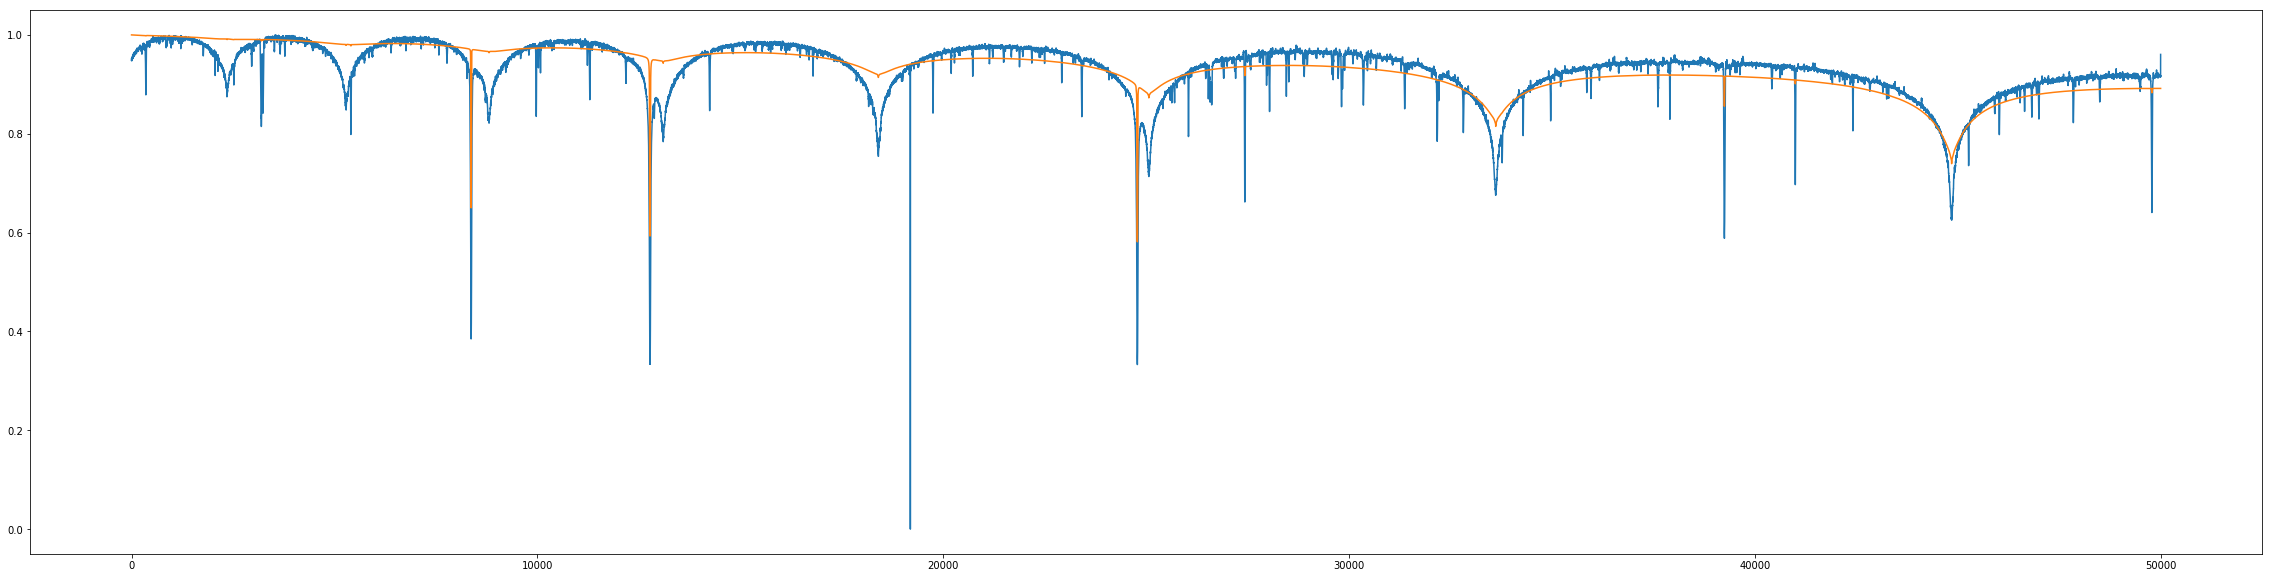

In [14]:
#left, right = [int(i * SPECTRA_FEATURES) for i in (0, 1)]
left, right = 700000, 750000
plt.figure(figsize=(40,10))
plt.plot(recreation)
plt.plot(normalized_spectra[INDEX])

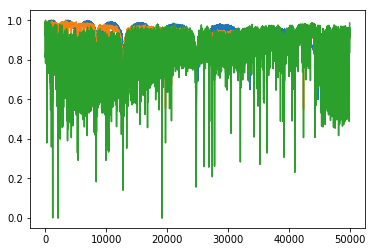

In [17]:
plt.plot(recreate_spectra(normalized_spectra[0], ws, bs))
plt.plot(recreate_spectra(normalized_spectra[1], ws, bs))
#plt.plot(recreate_spectra(normalized_spectra[2], ws, bs))

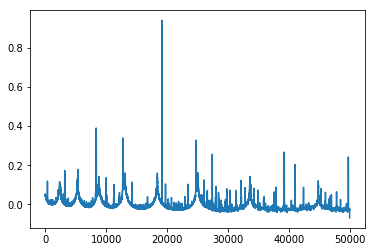

In [15]:
plt.plot(normalized_spectra[INDEX] - recreation)